In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, int64
import random
%matplotlib inline

In [3]:
def build_neighbor_pos_dictionary(n_row,n_col):
    list_of_all_pos_in_ca = [(r,c) for r in np.arange(0,n_row) for c in np.arange(0,n_col)]
    dict_of_neighbors_pos_lists = {pos:build_neighbor_pos_list(pos,n_row,n_col) for pos in list_of_all_pos_in_ca}
    return dict_of_neighbors_pos_lists

In [4]:
def build_neighbor_pos_list(pos, n_row, n_col):
    r,c = pos
    l = [(r+i,c+j)
         for i in [-1,0,1]
         for j in [-1,0,1]
         if 0 <= r+i < n_row
         if 0 <= c+j < n_col
         if not(j==0 and i==0)]
    return l

In [5]:
binomial = np.random.binomial
shuffle = np.random.shuffle
random_choice = random.choice

In [6]:
@jit(int64(), nopython=True)
def divide_symmetrically_q():
    SYMMETRIC_DIVISION_PROB = 0.3
    verdict = binomial(1, SYMMETRIC_DIVISION_PROB)
    return verdict

In [7]:
@jit(int64(), nopython=True)
def divide_q():
    DIVISION_PROB = 0.0416
    verdict = binomial(1, DIVISION_PROB)
    return verdict

In [8]:
@jit(int64(), nopython=True)
def die_q():
    DEATH_PROB = 0.01
    verdict = binomial(1,DEATH_PROB)
    return verdict

In [9]:
class CancerCell(object):
    def __init__(self, pos, dictionary_of_neighbor_pos_lists):
        self.pos = pos
        self.divisions_remaining = 10
        self.neighbor_pos_list = dictionary_of_neighbor_pos_lists[self.pos]
        self.PLOT_ID = 1
        
    def locate_empty_neighbor_position(self, agent_dictionary):
        empty_neighbor_pos_list = [pos for pos in self.neighbor_pos_list if pos not in agent_dictionary]
        if empty_neighbor_pos_list:
            empty_pos = random_choice(empty_neighbor_pos_list)
            return empty_pos
        else:
            return None
    
    def act(self, agent_dictionary, dictionary_of_neighbor_pos_lists):
        divide = divide_q()
        if divide == 1:
            empty_pos = self.locate_empty_neighbor_position(agent_dictionary)
            if empty_pos is not None:
                daughter_cell = CancerCell(empty_pos, dictionary_of_neighbor_pos_lists)
                agent_dictionary[empty_pos] = daughter_cell
                
                self.divisions_remaining -= 1
        
        spontaneous_death = die_q()
        if self.divisions_remaining <= 0 or spontaneous_death ==1:
            del agent_dictionary[self.pos]
        

In [10]:
class CancerStemCell(CancerCell):
    def __init__(self, pos, dictionary_of_neighbor_pos_lists):
        super(CancerStemCell, self).__init__(pos, dictionary_of_neighbor_pos_lists)
        self.PLOT_ID = 2
    
    def act(self, agent_dictionary, dictionary_of_neighbor_pos_lists):
        divide = divide_q()
        if divide == 1:
            empty_pos = self.locate_empty_neighbor_position(agent_dictionary)
            if empty_pos is not None:
                symmetric_division = divide_symmetrically_q()
                if symmetric_division == 1:
                    daughter_cell = CancerStemCell(empty_pos, dictionary_of_neighbor_pos_lists)
                else:
                    daughter_cell = CancerCell(empty_pos, dictionary_of_neighbor_pos_lists)
                agent_dictionary[empty_pos] = daughter_cell

In [14]:
N_ROW=2000
N_COL=2000
MAX_REPS=6*20*5
DICTIONARY_OF_NEIGHBOR_POS_LISTS = build_neighbor_pos_dictionary(N_ROW,N_COL)
center_r = int(round(N_ROW/2.0))
center_c = int(round(N_COL/2.0))
center_pos = (center_r, center_c)

initial_cancer_stem_cell = CancerStemCell(center_pos, DICTIONARY_OF_NEIGHBOR_POS_LISTS)
cell_dictionary = {center_pos:initial_cancer_stem_cell}

for rep in range(MAX_REPS):
    cell_list = cell_dictionary.values()
    shuffle(cell_list)
    for cell in cell_list:
        cell.act(cell_dictionary, DICTIONARY_OF_NEIGHBOR_POS_LISTS)
    

In [15]:
visualization_matrix = np.zeros((N_ROW,N_COL))
for cell in cell_dictionary.values():
    visualization_matrix[cell.pos] = cell.PLOT_ID
    

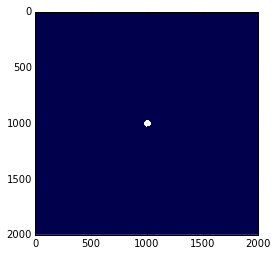

In [16]:
plt.imshow(visualization_matrix, interpolation='none', cmap='seismic', vmin=0, vmax=2)

Now we give 1 fraction of RT, dose 2Gy, $\alpha$/$\beta$ = 10

In [17]:
cell_list = cell_dictionary.values()

N= number of cancer cells in the tumour

In [46]:
N=len(cell_list)
alpha_beta_ratio=3
dose=2
RT_DEATH_PROB = 1 - (np.exp(-alpha_beta_ratio*dose - dose*dose))

In [48]:
for cell in cell_list:
    verdict = binomial(1,RT_DEATH_PROB)
    if verdict==1:
        cell_list.remove(cell)

In [49]:
len(cell_list)

1474

In [47]:
RT_DEATH_PROB

0.99995460007023751